# LL Surfaces

---

Aditya Marathe

**Aims**:

- Understand how PyOscCalc works...
    - *My understanding*: It simulates matter effects on oscillation prob.
- Calculate LL for our data...

Useful equations for an oscillation fit:

$$
    \text{ln}\mathscr{L} = - \sum_{i=1}^N \left( \text{P}_i(\text{Osc. Params.}) - \text{O}_i + \text{O}_i \times \text{ln} \frac{\text{O}_i}{\text{P}_i(\text{Osc. Params.})} \right)
$$

$$
    \chi^2 = - 2 \text{ln} \mathscr{L}
$$

where $\text{P}_i(\text{Osc. Params.})$ is the predicted energy distribution calculated by passing the possible oscillation parameters to an oscillation calculator (PyOscCalc) and $\text{O}_i$ is the observed energy distribution from the experiment.

What are the oscillation parameters are we fitting for?

- $\text{sin}^2 \theta_{23}$
- $\Delta m_{31}^2$
- $\delta_\text{CP}$

Stuff we cannot fit, so we just constrain them...

- $\text{sin}^2 \theta_{12} = 0.307$
- $\text{sin}^2 \theta_{13} = 0.0210 \pm 0.0011$
- $\Delta m_{21}^2 = 7.53 \times 10^{-5} \;\; \text{eV}^2$


In [1]:
%matplotlib inline

import numpy as np

import matplotlib as mlp
from matplotlib import pyplot as plt

In [2]:
import sys

sys.path.insert(1, './../../pyosccalc/')
sys.path.insert(1, './../')

In [3]:
import ana
from utils import *
from cuts import *

In [4]:
from OscCalc import OscCalc
from FluxTools import FluxTools, LogNormalFlux
from FitTools import FitTools

In [5]:
osccalc = OscCalc()

In [6]:
# Calculating the oscillation probabilities...
# A small delta was added to the bin values to prevent a ZeroDivisionError

bins = np.linspace(0.1, 5, 10_000)

mu_survival = np.asarray(
    [osccalc.MuToMu(energy) for energy in bins]
)
e_appearance = np.asarray(
    [osccalc.MuToElec(energy) for energy in bins]
)
tau_appearance = np.asarray(
    [osccalc.MuToTau(energy) for energy in bins]
)

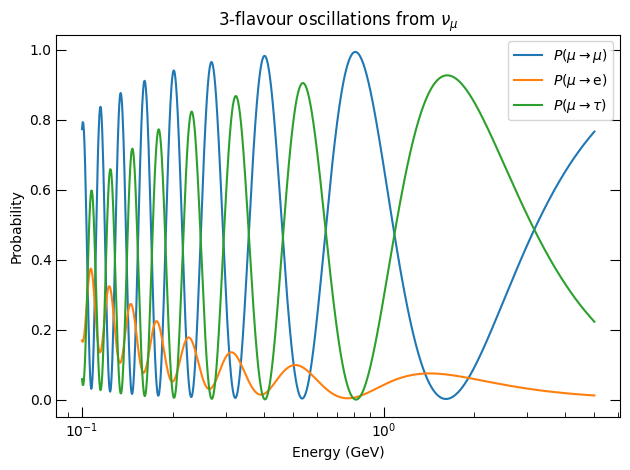

In [7]:
fig, ax = custom_subplots()

ax.plot(bins, mu_survival, label=r'$P(\mu\rightarrow\mu)$')
ax.plot(bins, e_appearance, label=r'$P(\mu\rightarrow\text{e})$')
ax.plot(bins, tau_appearance, label=r'$P(\mu\rightarrow\tau)$')

ax.legend()

ax.set_xscale('log')

ax.set_title(r'3-flavour oscillations from $\nu_\mu$')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Probability')

plt.tight_layout();

In [8]:
fluxtools = FluxTools()
lognormflux = LogNormalFlux()

pdf = fluxtools.pdfwrap(lognormflux)

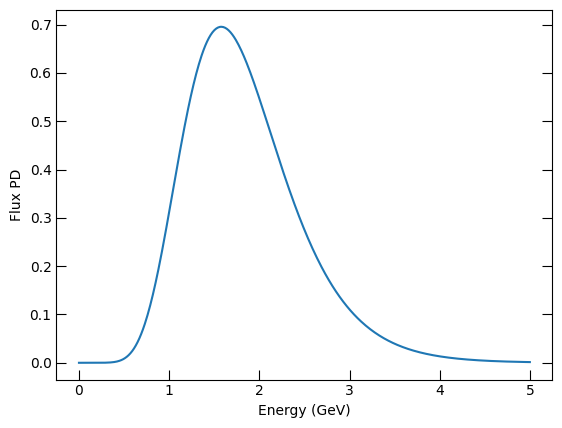

In [9]:
fig, ax = custom_subplots()

bins = np.linspace(0, 5, pdf.shape[0])

ax.plot(bins, pdf)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux PD');

In [10]:
# Create an experiment
bin_weights = fluxtools.getNuMuAsimov(flux=lognormflux, osccalc=osccalc)
bin_edges = fluxtools.binEdges

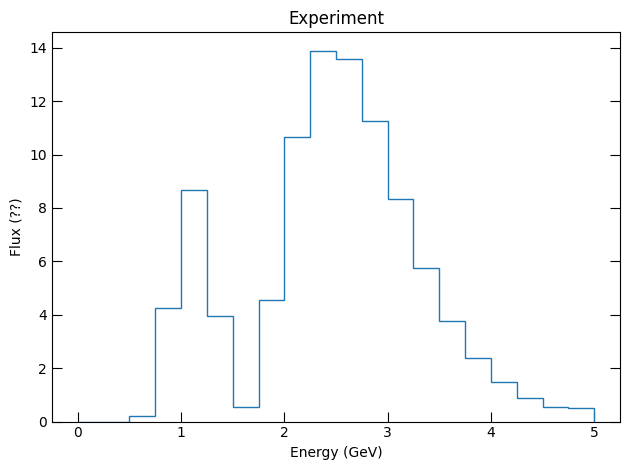

In [11]:
fig, ax = custom_subplots()

ax.hist(bin_edges[:-1], bin_edges, weights=bin_weights, histtype='step')

ax.set_title('Experiment')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (??)')

plt.tight_layout();

In [12]:
# Experiments in a bunch of fake universes...
exp_universes = [
    fluxtools.genNuMuExperiment(lognormflux, osccalc) for _ in range(10_000)
]

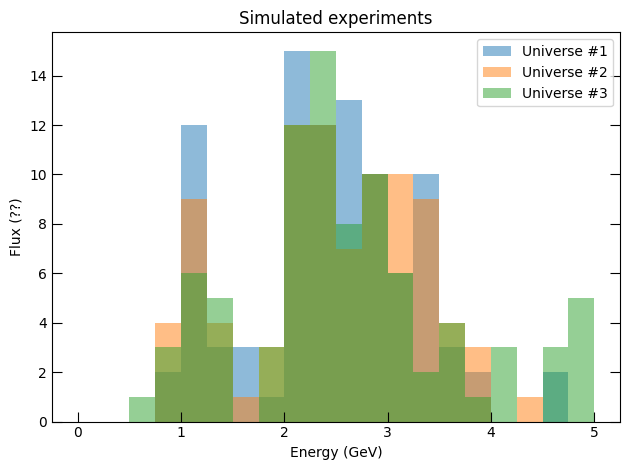

In [13]:
fig, ax = custom_subplots()

for i, exp_universe in enumerate(exp_universes[:3]):
    ax.hist(
        bin_edges[:-1], 
        bin_edges, 
        weights=exp_universe, 
        alpha=0.5,
        label=f'Universe #{i + 1}'
    )

ax.legend()

ax.set_title('Simulated experiments')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (??)')

plt.tight_layout();

In [14]:
# Calculating Least Likelihood...

# Possible osc. parameters in the multi-verse...
d_m32_array = np.linspace(2.2E-3, 2.6E-3, 10)
sin_sq_23_array = np.linspace(0.35, 0.65, 12)
d_cp_array = np.linspace(0, 2 * np.pi, 6)

asimov_array = fluxtools.makeNuMuAsimovArray(
    lognormflux, 
    osccalc,
    d_m32_array,
    sin_sq_23_array,
    d_cp_array
)

mu_ll_array = [
    [
        [
            FitTools.getPoissonLL(asimov, bin_weights) for asimov in asimov_row
        ] for asimov_row in asimov_mat
    ] for asimov_mat in asimov_array
]

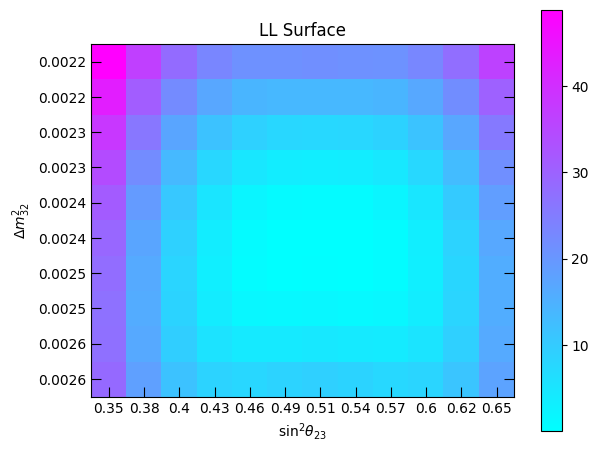

In [15]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

## LL (Current cuts)

In [16]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [17]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C9_DIR  # type: ignore
    ]
)

In [18]:
cuts = ana.Cuts.init_nova_cuts()

In [19]:
full_cut_table = cuts.apply_all_cuts(data.table)

In [20]:
energy_spectrum = full_cut_table['rec.energy.numu.lstmnu']

In [27]:
osc_spectrum_weights = 1 - np.sin(1.27 * 2.35E-3 * 810 / energy_spectrum)**2

$$
    P = 1 - \sin^2(... / E)
$$

$$
    \sin^2(.../E) = 1 - P
    \sin(... / E) = \sqrt{1 - P}
    ... / E = \arcsin(\sqrt{1 - P})
    E = ... / \arcsin(\sqrt{1 - P})
$$

In [28]:
"""fluxVals=flux.flux(self.xvals)
binVals=[0]*(len(self.binEdges)-1)
thisBin=0
lastx=0
for x,y in zip(self.xvals,fluxVals):
    if(thisBin<len(self.binEdges)-2):
        if(x>self.binEdges[thisBin+1]):
            thisBin+=1
    binVals[thisBin]+=y*(x-lastx)*probcalc(x)
    lastx=x"""

'fluxVals=flux.flux(self.xvals)\nbinVals=[0]*(len(self.binEdges)-1)\nthisBin=0\nlastx=0\nfor x,y in zip(self.xvals,fluxVals):\n    if(thisBin<len(self.binEdges)-2):\n        if(x>self.binEdges[thisBin+1]):\n            thisBin+=1\n    binVals[thisBin]+=y*(x-lastx)*probcalc(x)\n    lastx=x'

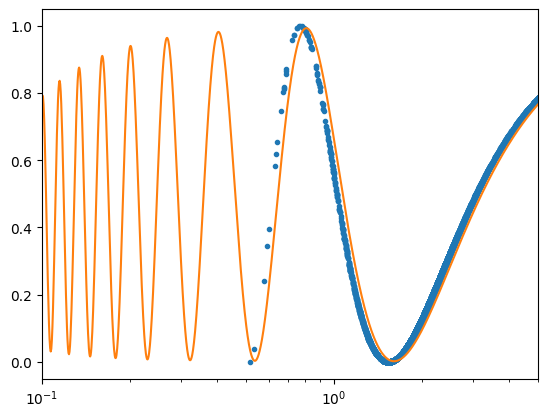

In [29]:
plt.plot(energy_spectrum, osc_spectrum_weights, '.')
plt.plot(np.linspace(0.1, 5, 10_000), mu_survival)
plt.xlim(0.1, 5)
plt.xscale('log');

C:\Users\Shrey\AppData\Local\Temp\ipykernel_23204\1439916387.py:4: RuntimeWarning: invalid value encountered in arcsin
  weights=1.27 * 2.35E-3 * 810 / np.arcsin(np.sqrt(asimov_array[5][5][5])),


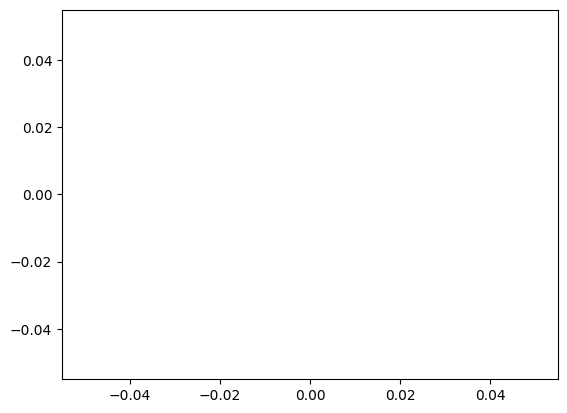

In [33]:
plt.hist(
    fluxtools.binEdges[:-1], 
    fluxtools.binEdges, 
    weights=1.27 * 2.35E-3 * 810 / np.arcsin(np.sqrt(asimov_array[5][5][5])),
    density=True
);

In [32]:
flux = fluxtools.getAsimov(flux=lognormflux, probcalc=osc_spectrum_weights)

TypeError: 'Series' object is not callable